In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00


In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.3 MB/s eta 0:00:00


In [4]:
#imports
import pandas as pd
import functools
import sys

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers
from datasets import Dataset
import re

In [5]:
#setting seed value for minimizing randomness
seed = 0

torch.manual_seed(seed)

In [6]:
#using NERT base as the model
transformer_name = 'bert-base-uncased'

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

In [102]:
data = pd.read_csv('/content/drive/MyDrive/Internship_task/training.data/training.data', delimiter = "\t", names = ["text"]) #data import

In [103]:
data.shape

(15452, 1)

In [104]:
data.head()

,text
0,DESC:manner How did serfdom develop in and the...
1,ENTY:cremat What films featured the character ...
2,DESC:manner How can I find a list of celebriti...
3,ENTY:animal What fowl grabs the spotlight afte...
4,ABBR:exp What is the full form of .com ?


In [105]:
str(data.values[0])#checking the structure of the imprted data

"['DESC:manner How did serfdom develop in and then leave Russia ?']"

In [106]:
data = data.dropna()#dropping NA

In [107]:
#extracting classes / labels from the text in the dataset
classes = []
pattern = "[A-Z]*\:[a-z]*"

for i in range (len(data)):
  label = re.findall(pattern, str(data.values[i]))
  classes.append(label[0])

In [108]:
len(classes) #checking if the extracted labes match the number of rows in the main dataset

15452

In [109]:
data['class'] = classes #adding the class column in the main dataset

In [110]:
data['text'] = data['text'].replace(pattern, '', regex=True, limit=1) #removing the class lables form the text

In [111]:
# Remove unnecessary spaces from the first column
data['text'] = data['text'].str.strip()

In [112]:
labels = data['class'].unique() #taking all the vailable classes in the dataset

In [113]:
#label encoding classes
le = LabelEncoder()
data['class'] = le.fit_transform(data['class'])

# Print label encoding mappings
print("Label Encoding Mappings:")
label_mappings = dict(zip(le.classes_, le.transform(le.classes_)))
for label, encoded_value in label_mappings.items():
    print(f"{label}: {encoded_value}")

Label Encoding Mappings:
ABBR:abb: 0
ABBR:exp: 1
DESC:def: 2
DESC:desc: 3
DESC:manner: 4
DESC:reason: 5
ENTY:animal: 6
ENTY:body: 7
ENTY:color: 8
ENTY:cremat: 9
ENTY:currency: 10
ENTY:dismed: 11
ENTY:event: 12
ENTY:food: 13
ENTY:instru: 14
ENTY:lang: 15
ENTY:letter: 16
ENTY:other: 17
ENTY:plant: 18
ENTY:product: 19
ENTY:religion: 20
ENTY:sport: 21
ENTY:substance: 22
ENTY:symbol: 23
ENTY:techmeth: 24
ENTY:termeq: 25
ENTY:veh: 26
ENTY:word: 27
HUM:desc: 28
HUM:gr: 29
HUM:ind: 30
HUM:title: 31
LOC:city: 32
LOC:country: 33
LOC:mount: 34
LOC:other: 35
LOC:state: 36
NUM:code: 37
NUM:count: 38
NUM:date: 39
NUM:dist: 40
NUM:money: 41
NUM:ord: 42
NUM:other: 43
NUM:perc: 44
NUM:period: 45
NUM:speed: 46
NUM:temp: 47
NUM:volsize: 48
NUM:weight: 49


In [114]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test/validation
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Printing the sizes of the split datasets
print("Train data size:", train_data.shape)
print("Test data size:", test_data.shape)

Train data size: (12361, 2)
Test data size: (3091, 2)


In [115]:
# Convert DataFrame to Arrow Dataset
train_data = Dataset.from_pandas(train_data)
test_data = Dataset.from_pandas(test_data)

In [116]:
train_data #checking structure of Arrow dataset

Dataset({
    features: ['text', 'class', '__index_level_0__'],
    num_rows: 12361
})

In [117]:
#Tokenizing and embedding
def tokenize_and_numericalize_data(example, tokenizer):
    ids = tokenizer(example['text'], truncation=True)['input_ids']
    return {'ids': ids}

In [118]:
#Tokenizing and embedding
train_data = train_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})
test_data = test_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})

Map:   0%|          | 0/12361 [00:00<?, ? examples/s]

Map:   0%|          | 0/3091 [00:00<?, ? examples/s]

In [119]:
pad_index = tokenizer.pad_token_id #padding index to make all the strings in the data set of the same length

In [120]:
test_size = 0.2
#creating validation set
train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

In [121]:
#converting all the splits tran, test and valid in to pytorch format
train_data = train_data.with_format(type='torch', columns=['ids', 'class'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'class'])
test_data = test_data.with_format(type='torch', columns=['ids', 'class'])

In [122]:
transformer = transformers.AutoModel.from_pretrained(transformer_name) #making transformer object

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [123]:
#checking the number of hidden size in the transformer
transformer.config.hidden_size

768

In [124]:
import torch
import torch.nn as nn
#from transformers import *

class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size

        # Add a CNN layer
        self.cnn = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)

        self.fc = nn.Linear(hidden_dim, output_dim)

        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:, 0, :]  # Take the first token

        # Reshape for Conv1d input
        cls_hidden = cls_hidden.unsqueeze(2)  # [batch size, hidden dim, 1]

        # Move tensors to the same device
        device = hidden.device
        cls_hidden = cls_hidden.to(device)

        # Apply the CNN layer
        cls_hidden = self.cnn(cls_hidden)

        # Reshape back
        cls_hidden = cls_hidden.squeeze(2)  # [batch size, hidden dim]

        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction


In [125]:
output_dim = len(pd.Series(train_data['class']).unique()) #taking the output dimention
freeze = False #basically letting the model to update weights of hidden layers after each iteration

In [126]:
output_dim

50

In [127]:
model = Transformer(transformer, output_dim, freeze) #initializing transformer object

In [128]:
def count_parameters(model): #checking total number of trainable parameters
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 111,290,930 trainable parameters


In [129]:
lr = 1e-5 #setting lerning rate

optimizer = optim.Adam(model.parameters(), lr=lr) #setting optimizer for the model

In [130]:
criterion = nn.CrossEntropyLoss() #setting crossentropy loss as this is a multiclass classification

In [131]:
device = torch.device('cuda') #setting device to cuda so we can utilize gpu

In [132]:
device #checking device

device(type='cuda')

In [133]:
model = model.to(device) #transfering model and loss criteria to cuda device
criterion = criterion.to(device)

In [134]:

def collate(batch, pad_index):
    # Extract the 'ids' field from each item in the batch
    batch_ids = [i['ids'] for i in batch]

    # Pad the sequences in the batch to have equal lengths
    # using the pad_sequence function from nn.utils.rnn module
    # with the specified padding value and set batch_first=True
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)

    # Extract the 'class' field from each item in the batch
    batch_class = [i['class'] for i in batch]

    # Stack the classs in the batch to create a tensor
    batch_class = torch.stack(batch_class)

    # Create a dictionary with the 'ids' and 'class' fields
    # and return it as the collated batch
    batch = {'ids': batch_ids,
             'class': batch_class}

    return batch

In [135]:
batch_size = 4

# Create a partial function 'collate' with the 'pad_index' argument set to 'pad_index' value
collate = functools.partial(collate, pad_index=pad_index)

# Create a training data loader
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    collate_fn=collate,
    shuffle=True
)

# Create a validation data loader
valid_dataloader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=batch_size,
    collate_fn=collate
)

# Create a test data loader
test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    collate_fn=collate
)

In [136]:
import tqdm
import sys

def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='Training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['class'].to(device)

        optimizer.zero_grad() #remove the accumulated gradients from previous iterations

        # Forward pass
        predictions = model(ids)
        loss = criterion(predictions, label) #crossentropy loss

        # Backward pass and optimization
        loss.backward() #backward pass
        optimizer.step() #updation

        # Calculate accuracy
        accuracy = get_accuracy(predictions, label)

        # Append loss and accuracy to epoch lists
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy)

    return epoch_losses, epoch_accs

In [137]:
def evaluate(dataloader, model, criterion, device):
    model.eval()  # Sets the model to evaluation mode
    epoch_losses = []  # List to store the losses for each batch
    epoch_accs = []  # List to store the accuracies for each batch

    with torch.no_grad():  # Disables gradient computation
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)  # Move input tensors to the specified device (e.g., GPU)
            label = batch['class'].to(device)  # Move target tensors to the specified device
            prediction = model(ids)  # Forward pass through the model to obtain predictions
            loss = criterion(prediction, label)  # Calculate the loss using the provided criterion
            accuracy = get_accuracy(prediction, label)  # Calculate the accuracy
            epoch_losses.append(loss.item())  # Store the loss value in the list
            epoch_accs.append(accuracy)  # Store the accuracy value in the list

    return epoch_losses, epoch_accs  # Return the lists of losses and accuracies

In [138]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape #batch size
    predicted_classes = prediction.argmax(dim=-1) #get the predicted labels
    #correct_predictions = predicted_classes.eq(label).sum()
    correct_predictions = (predicted_classes == label).sum().item()  #compare and check the predicitions
    accuracy = correct_predictions / batch_size #accuracy is computed by dividing the number of correct predictions by the batch size
    return accuracy

In [139]:
torch.cuda.empty_cache() #emptying cuda cache memory

In [140]:
torch.cuda.memory_summary(device=None, abbreviated=False) #checking summary of cuda memory usage

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 451972 KiB |   2559 MiB |  10648 GiB |  10648 GiB |\n|       from large pool | 451328 KiB |   2555 MiB |   8902 GiB |   8901 GiB |\n|       from small pool |    644 KiB |     61 MiB |   1746 GiB |   1746 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 451972 KiB |   2559 MiB |  10648 GiB |  10648 GiB |\n|       from large pool | 451328 KiB |   2555 MiB |

In [141]:
n_epochs = 3
best_valid_loss = float('inf')

train_losses = []   # List to store train losses
train_accs = []     # List to store train accuracies
valid_losses = []   # List to store validation losses
valid_accs = []     # List to store validation accuracies

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)  # Train the model
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)  # Evaluate the model on validation data

    train_losses.extend(train_loss)   # Append train losses to the list
    train_accs.extend(train_acc)      # Append train accuracies to the list
    valid_losses.extend(valid_loss)   # Append validation losses to the list
    valid_accs.extend(valid_acc)      # Append validation accuracies to the list

    epoch_train_loss = np.mean(train_loss)    # Calculate mean train loss for the epoch
    epoch_train_acc = np.mean(train_acc)      # Calculate mean train accuracy for the epoch
    epoch_valid_loss = np.mean(valid_loss)    # Calculate mean validation loss for the epoch
    epoch_valid_acc = np.mean(valid_acc)      # Calculate mean validation accuracy for the epoch

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'transformer.pt')  # Save the model if the validation loss improves

    print(f'Epoch: {epoch+1}/{n_epochs}')
    print(f'Train Loss: {epoch_train_loss:.3f}, Train Accuracy: {epoch_train_acc:.3f}')
    print(f'Validation Loss: {epoch_valid_loss:.3f}, Validation Accuracy: {epoch_valid_acc:.3f}')
    print()


evaluating...: 100%|██████████| 619/619 [00:09<00:00, 64.08it/s]
Epoch: 1/3
Train Loss: 1.349, Train Accuracy: 0.718
Validation Loss: 0.419, Validation Accuracy: 0.914

evaluating...: 100%|██████████| 619/619 [00:07<00:00, 79.68it/s]
Epoch: 2/3
Train Loss: 0.286, Train Accuracy: 0.945
Validation Loss: 0.167, Validation Accuracy: 0.965

evaluating...: 100%|██████████| 619/619 [00:07<00:00, 79.79it/s]
Epoch: 3/3
Train Loss: 0.103, Train Accuracy: 0.982
Validation Loss: 0.107, Validation Accuracy: 0.981



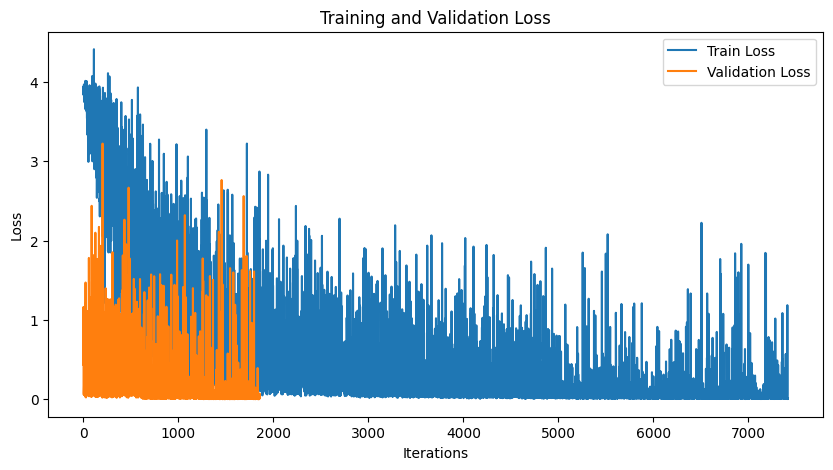

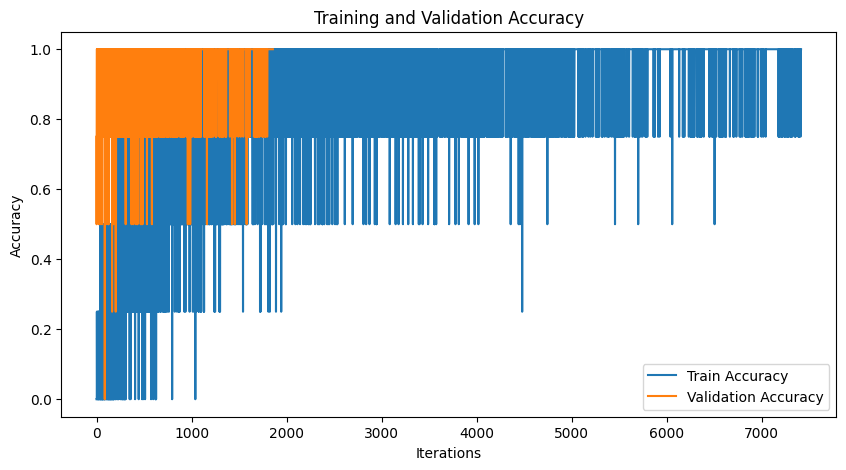

In [142]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting the training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(valid_accs, label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [143]:
print(model) #print model structure

Transformer(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
#model.load_state_dict(torch.load('/kaggle/input/model-fr/transformer_new.pt'))

<All keys matched successfully>

In [144]:
test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)  # Evaluate the model on test data

epoch_test_loss = np.mean(test_loss)    # Calculate mean test loss
epoch_test_acc = np.mean(test_acc)      # Calculate mean test accuracy

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')  # Print the test loss and accuracy

evaluating...: 100%|██████████| 773/773 [00:15<00:00, 48.65it/s]
test_loss: 0.125, test_acc: 0.979


In [145]:
def predict_(text, model, tokenizer, device):
    # Tokenize the input text
    ids = tokenizer(text)['input_ids']

    # Convert the tokenized input to a PyTorch tensor and move it to the specified device
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)

    # Make the prediction using the model
    prediction = model(tensor).squeeze(dim=0)

    # Apply softmax to obtain probabilities
    probability = torch.softmax(prediction, dim=-1)

    # Get the predicted class label
    predicted_class = prediction.argmax(dim=-1).item()

    # Get the predicted probability for the predicted class
    predicted_probability = probability[predicted_class].item()

    # Return the predicted class label and predicted probability
    return predicted_class, predicted_probability


# **Test on new text **

In [155]:
#making dicitonary of the class labels
dictionary = {
    'ABBR:abb': 0,
    'ABBR:exp': 1,
    'DESC:def': 2,
    'DESC:desc': 3,
    'DESC:manner': 4,
    'DESC:reason': 5,
    'ENTY:animal': 6,
    'ENTY:body': 7,
    'ENTY:color': 8,
    'ENTY:cremat': 9,
    'ENTY:currency': 10,
    'ENTY:dismed': 11,
    'ENTY:event': 12,
    'ENTY:food': 13,
    'ENTY:instru': 14,
    'ENTY:lang': 15,
    'ENTY:letter': 16,
    'ENTY:other': 17,
    'ENTY:plant': 18,
    'ENTY:product': 19,
    'ENTY:religion': 20,
    'ENTY:sport': 21,
    'ENTY:substance': 22,
    'ENTY:symbol': 23,
    'ENTY:techmeth': 24,
    'ENTY:termeq': 25,
    'ENTY:veh': 26,
    'ENTY:word': 27,
    'HUM:desc': 28,
    'HUM:gr': 29,
    'HUM:ind': 30,
    'HUM:title': 31,
    'LOC:city': 32,
    'LOC:country': 33,
    'LOC:mount': 34,
    'LOC:other': 35,
    'LOC:state': 36,
    'NUM:code': 37,
    'NUM:count': 38,
    'NUM:date': 39,
    'NUM:dist': 40,
    'NUM:money': 41,
    'NUM:ord': 42,
    'NUM:other': 43,
    'NUM:perc': 44,
    'NUM:period': 45,
    'NUM:speed': 46,
    'NUM:temp': 47,
    'NUM:volsize': 48,
    'NUM:weight': 49
}

label_dict = {v: k for k, v in dictionary.items()} #reversing the dictionary because the above was not appropriate accrding to our case


In [158]:
text = "what country are you from?"

predicted = predict_(text, model, tokenizer, device)
print("label predicted = ",label_dict[predicted[0]]," | ", "with probability of ", predicted[1])

label predicted =  LOC:country  |  with probability of  0.9931960105895996


In [159]:
import torch
import tqdm
import sys
from sklearn.metrics import classification_report

def evaluate(dataloader, model, criterion, device):
    model.eval()  # Sets the model to evaluation mode
    epoch_losses = []  # List to store the losses for each batch
    epoch_accs = []  # List to store the accuracies for each batch
    all_predictions = []  # List to store all predictions
    all_labels = []  # List to store all labels

    with torch.no_grad():  # Disables gradient computation
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)  # Move input tensors to the specified device (e.g., GPU)
            label = batch['class'].to(device)  # Move target tensors to the specified device
            prediction = model(ids)  # Forward pass through the model to obtain predictions
            loss = criterion(prediction, label)  # Calculate the loss using the provided criterion
            accuracy = get_accuracy(prediction, label)  # Calculate the accuracy
            epoch_losses.append(loss.item())  # Store the loss value in the list
            epoch_accs.append(accuracy)  # Store the accuracy value in the list

            # Convert prediction and label tensors to CPU and extract the values
            prediction_cpu = prediction.cpu().detach().numpy()
            label_cpu = label.cpu().detach().numpy()

            # Extend the lists with predictions and labels
            all_predictions.extend(prediction_cpu)
            all_labels.extend(label_cpu)

    # Convert predictions and labels to numpy arrays
    all_predictions = np.argmax(all_predictions, axis=1)
    all_labels = np.array(all_labels)

    # Print classification report
    report = classification_report(all_labels, all_predictions)
    print(report)

    return epoch_losses, epoch_accs  # Return the lists of losses and accuracies

In [160]:
test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|██████████| 773/773 [00:11<00:00, 64.77it/s]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.85      0.91      0.88        43
           2       0.97      0.95      0.96       245
           3       0.95      0.97      0.96       149
           4       1.00      0.99      0.99       139
           5       0.98      1.00      0.99       120
           6       0.97      0.97      0.97        72
           7       0.77      1.00      0.87        10
           8       1.00      1.00      1.00        27
           9       1.00      1.00      1.00       122
          10       0.00      0.00      0.00         1
          11       0.97      1.00      0.99        72
          12       0.91      1.00      0.95        31
          13       0.98      0.96      0.97        46
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00        10
          16    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
